In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import itertools

Gather Data:

I have retrieved a dataset from Kaggle about wine. I chose this dataset as it had written reviews, but could also be classified by points. For this project, I will be using those two features alone.

https://www.kaggle.com/datasets/zynicide/wine-reviews?select=winemag-data_first150k.csv

In [2]:
# Reading the wine dataset and dropping irrelevant columns
wdf = pd.read_csv('wine.csv').drop(['Unnamed: 0', 'country', 'designation', 'price', 'province', 'region_1', 'region_2', 'variety', 'winery'], axis = 1) 

Identify an Unsupervised Learning Problem:

I will be reducing the dataset to the description of each wine along with the rating that was given to each. I will use an unsupervised learning model (NMF) to try and determine what rating the wine was given based on the description. After, I will be comparing it to a supervised model (RF) to see which works better in this instance.

Exploratory Data Analysis:

I will start with simple EDA to attempt to simplify and understand the data.

In [3]:
# Displaying the first few rows of the dataset
print("Head of dataset")
print(wdf.head())
print()
print("Length of dataset:")
print(len(wdf)) # Checking the number of rows in the dataset

Head of dataset
                                         description  points
0  This tremendous 100% varietal wine hails from ...    96.0
1  Ripe aromas of fig, blackberry and cassis are ...    96.0
2  Mac Watson honors the memory of a wine once ma...    96.0
3  This spent 20 months in 30% new French oak, an...    96.0
4  This is the top wine from La Bégude, named aft...    95.0

Length of dataset:
44789


From this we learn that there are two features being used, description and points.

In [4]:
# Handling missing values
print("Nulls in dataset:")
print(wdf.isnull().sum())
wdf = wdf.dropna()  # Dropping rows with missing values
print()
print("Length of dataset after dropping null values:")
print(len(wdf))  # Checking the number of rows after dropping missing values

Nulls in dataset:
description    0
points         1
dtype: int64

Length of dataset after dropping null values:
44788


There was one null value, which we removed.

In [5]:
# Handling duplicate entries
print("Dupes in dataset:")
print(wdf.duplicated().sum())
print()
print("Duplicated values:")
print(wdf.duplicated().unique())
wdf = wdf.drop_duplicates()  # Dropping duplicate rows
print()
print("Length of dataset after removing dupes:")
print(len(wdf))  # Checking the number of rows after dropping duplicates

Dupes in dataset:
4488

Duplicated values:
[False  True]

Length of dataset after removing dupes:
40300


There were lots of duplicates, which all seem to have been either false or true. We dropped them to avoid messing up data.

Now that we have cleaned the dataset, we will visualize the data.

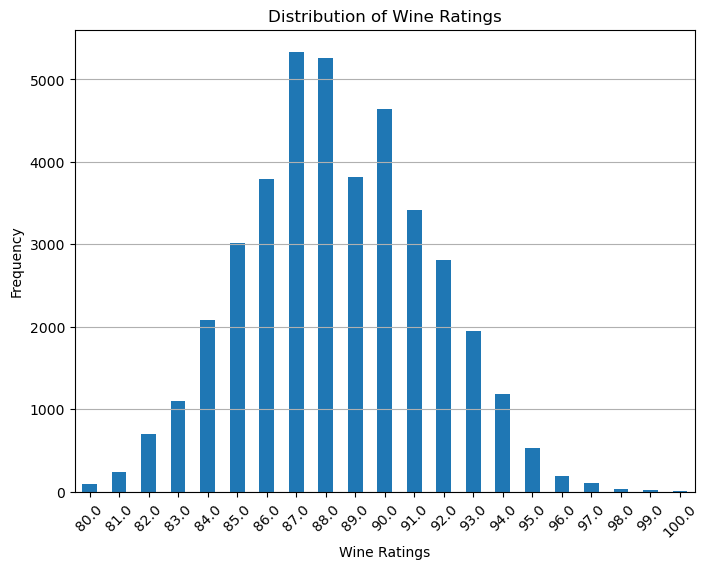

All values:
80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100


Min and Max:
80 100


In [6]:
# Visualizing the distribution of wine ratings
plt.figure(figsize=(8, 6))
wdf['points'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Wine Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Ratings')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
vals = np.sort(wdf['points'].unique())
print("All values:")
for i in range(20):
    print(int(vals[i]), end=', ')
print(int(vals[20]))
print()
print()
print("Min and Max:")
print(int(min(wdf['points'])), int(max(wdf['points'])))

It looks like points go from 80 to 100, incrementing by 1. 21 is too many bins for me, so lets group them by threes to leave us with 7.

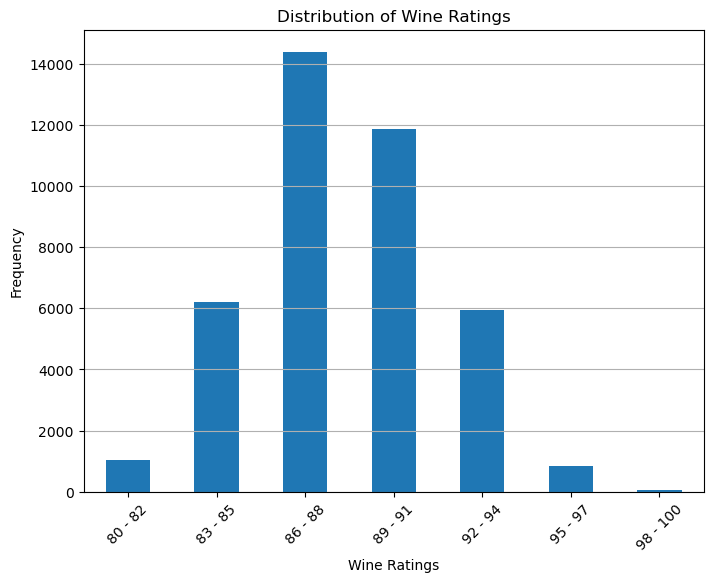

In [7]:
# Grouping wine ratings into ranges to reduce the number of bins
def map_to_range(value):
    if 80 <= value <= 82:
        return '80 - 82'
    elif 83 <= value <= 85:
        return '83 - 85'
    elif 86 <= value <= 88:
        return '86 - 88'
    elif 89 <= value <= 91:
        return '89 - 91'
    elif 92 <= value <= 94:
        return '92 - 94'
    elif 95 <= value <= 97:
        return '95 - 97'
    elif 98 <= value <= 100:
        return '98 - 100'
wdf['points'] = wdf['points'].apply(map_to_range)
plt.figure(figsize=(8, 6))
wdf['points'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Wine Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Wine Ratings')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

We now want to transform our data to be used in NMF. We will split our data into a train and test set and then use tfidf to numerically represent the descriptions.

In [8]:
# Transforming data for NMF
# Splitting the data into train and test sets
train, test = train_test_split(wdf, test_size=0.2, shuffle=False)
# Vectorizing textual descriptions using TF-IDF
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train['description'])
test_tfidf = vectorizer.transform(test['description'])

Perform Analysis:

In [9]:
# Running NMF to extract features and predict wine ratings
def runNMF(nmf):
    cats = train.copy()['points']
    accuracy = -100000000
    results = []
    permutations = list(itertools.permutations(np.arange(7)))
    m1 = {}
    for i, j in enumerate(cats.unique()):
        m1[i] = j
    for permutation in permutations:
        m2 = {}
        for i, j in enumerate(list(permutation)):
            m2[j] = m1[i]
        new = []
        for i in nmf:
            new.append(m2[i])
        a = (cats == new).sum()/len(cats)
        if a > accuracy:
            accuracy = a
            results = new
    print('Accuracy of NMF on data is:', accuracy)
    return accuracy, results

In [10]:
# Confusion matrix function for visualization
def cm(df, r):
        labels = ['80 - 82', '83 - 85', '86 - 88', '89 - 91', '92 - 94', '95 - 97', '98 - 100']
        cm = confusion_matrix(df, r, labels = labels)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='.0f', cmap='Reds', xticklabels = labels, yticklabels = labels)
        plt.xlabel('Pred')
        plt.ylabel('Act')
        plt.title('Pred vs Act')
        plt.show()

Accuracy of NMF on data is: 0.2169044665012407


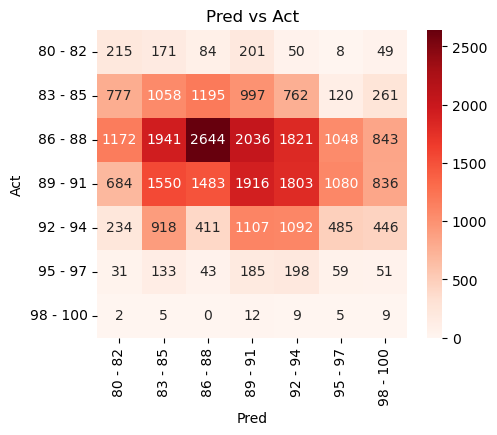

In [11]:
# Running NMF and evaluating accuracy
nmf = np.argmax(NMF(7).fit_transform(train_tfidf), axis = 1)
a, r = runNMF(nmf)
cm(train['points'], r)

The accuracy we got of about 21.7% is better than just guessing (1/7 or about 14.3%), but we definitely want to do better. Lets see how a supervised model performs with the same data.

Train Accuracy of RF: 0.999968982630273


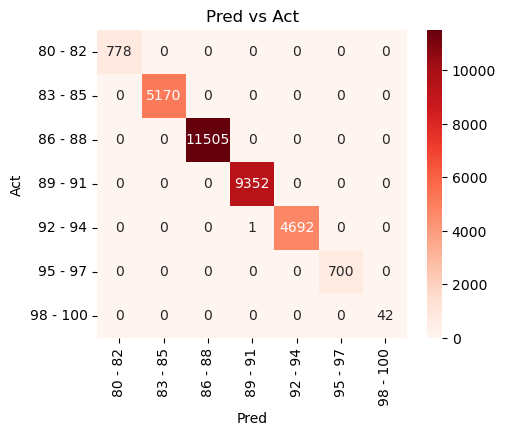

Test Accuracy of RF: 0.47667493796526056


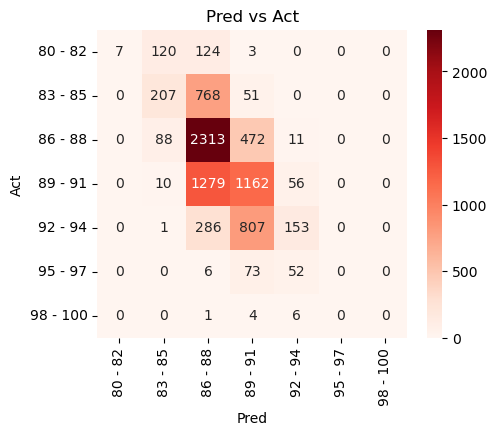

In [12]:
# Comparing with RF model
y_train = train.copy()['points']
y_test = test.copy()['points']
rf = RandomForestClassifier().fit(train_tfidf, y_train)
train_pred = rf.predict(train_tfidf)
test_pred = rf.predict(test_tfidf)
print("Train Accuracy of RF:", accuracy_score(y_train, train_pred))
cm(train['points'], train_pred)
print("Test Accuracy of RF:", accuracy_score(y_test, test_pred))
cm(test['points'], test_pred)

As you can see, the RF model got an accuracy of about 48%, which means it was over twice as accurate as the NMF model. Why is this? Let's talk about it.

Discussion and Conclusions:

We found that the RF model was more accurate. Why is this? RF is a supervised learning algorithm, whereas NMF is an unsupervised learning algorithm. A supervised model differs from an unsupervised model because a supervised model works on labeled data, which is to say the differences the model should distinguish in the test data are known and are pre-assigned in the training data. This is more accurate when working with data that has been labeled than an unsupervised model. An unsupervised model works on unlabeled data, which is better when the differences the model should distinguish in the test data are unknown and aren't pre-assigned in the training data. This is useful for discovering patterns you didn't know existed, and tying together ideas you didn't realize were correlated.

In this project, I performed wine data analysis using machine learning techniques. My goal was to predict wine ratings based solely on written descriptions and ratings, focusing on the 'description' and 'points' features from a Kaggle dataset. To start, I cleaned the dataset by dropping irrelevant columns, handling missing values, and eliminating duplicate entries to ensure the integrity of the data. This initial data preparation phase set a foundation for analysis. Next, I performed Exploratory Data Analysis (EDA), where I observed the distribution of wine ratings ('points') and transformed the text descriptions into numeric values using TF-IDF. For the modeling phase, I used two different approaches:

Unsupervised Learning with NMF:
I applied Non-Negative Matrix Factorization (NMF), an unsupervised learning algorithm, to extract features from the TF-IDF transformed descriptions. Despite not using the labels given in the data, NMF exhibited a moderate level of accuracy in predicting wine ratings based solely on descriptions.

Supervised Learning with RF:
Using Random Forest (RF), a supervised learning algorithm, I trained a model using the TF-IDF transformed descriptions along with labeled wine ratings. The RF model had significantly higher accuracy in predicting wine ratings compared to NMF, displaying the benefits of supervised learning with labeled data.
This comparison showed how important labeled data was in supervised learning when the goal is accuracy and precision.

In conclusion, my project explored the differeneces between unsupervised and supervised learning techniques in wine rating rating predictions. It showcased the strength of supervised learning when using labeled data, and its ability to result in more accurate predictions compared to unsupervised approaches in these instances.